In [1]:
import pandas as pd
import uproot as ur
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import torch

In [2]:
#file = ur.open('/home/jmsardain/JetCalib/Akt4EMTopo.topo_cluster.root')["ClusterTree"]
file = pd.read_csv('./fracdata.csv',' ')

#df = file.arrays(library="pd")
df1 = file.head(300000)
#df1.columns
df1.keys()

#df1 = file.head(80000)

/tmp/ipykernel_5413/253104733.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  file = pd.read_csv('./fracdata.csv',' ')


Index(['seqNumber', 'runNumber', 'eventNumber', 'avgMu', 'nPrimVtx', 'jetCnt',
       'jetCalE', 'jetCalPt', 'jetCalEta', 'jetCalPhi', 'jetRawE', 'jetRawPt',
       'jetRawEta', 'jetRawPhi', 'jetNConst', 'truthJetMatchRadius',
       'truthJetE', 'truthJetPt', 'truthJetRap', 'truthJetPhi', 'nCluster',
       'clusterIndex', 'cluster_nCells', 'cluster_nCells_tot', 'clusterECalib',
       'clusterPtCalib', 'clusterEtaCalib', 'clusterPhiCalib',
       'cluster_sumCellECalib', 'cluster_fracECalib', 'cluster_fracECalib_ref',
       'clusterE', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_sumCellE',
       'cluster_time', 'cluster_fracE', 'cluster_fracE_ref',
       'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT',
       'cluster_DM_WEIGHT', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
       'cluster_ENG_CALIB_OUT_L', 'cluster_ENG_CALIB_OUT_M',
       'cluster_ENG_CALIB_DEAD_T', 'cluster_ENG_CALIB_DEAD_L',
       'cluster_ENG_CALIB_DEAD_M', 'cluster_ENG_CALI

In [3]:
#test = []
#df = df1
#df1[[ 'eventNumber','jetCnt']][:35]

In [4]:
#for event in eventNumbers:
tempE = []
tempEta = []
temp_time = []
temp_labels = []
count_jets = 1
old_event = df1['jetCnt'][0]
old_jetCnt = df1['jetCnt'][0]
change_bol = False

SQUEEZE_clusterE = []
SQUEEZE_clusterEta = []
SQUEEZE_cluster_time = []
SQUEEZE_cluster_CENTER_LAMBDA = []
SQUEEZE_cluster_CENTER_MAG = []
SQUEEZE_clusterPhi = []
SQUEEZE_cluster_ENG_FRAC_EM = []
SQUEEZE_cluster_FIRST_ENG_DENS = []
SQUEEZE_cluster_LATERAL = []
SQUEEZE_cluster_LONGITUDINAL = []
SQUEEZE_cluster_PTD = []
SQUEEZE_cluster_ISOLATION = []
SQUEEZE_cluster_SECOND_TIME = []
SQUEEZE_cluster_SIGNIFICANCE = []
SQUEEZE_nPrimVtx = []
SQUEEZE_avgMu = []

labels = []

for index,row in df1.iterrows():
    
    SQUEEZE_clusterE.append(row['clusterE'])
    SQUEEZE_clusterEta.append(row['clusterEtaCalib'])
    SQUEEZE_cluster_time.append(row['cluster_time']/10)
    SQUEEZE_cluster_CENTER_LAMBDA.append(row['cluster_CENTER_LAMBDA']/100)
    SQUEEZE_cluster_CENTER_MAG.append(row['cluster_CENTER_MAG']/1000)
    SQUEEZE_clusterPhi.append(row['clusterPhi'])
    SQUEEZE_cluster_ENG_FRAC_EM.append(row['cluster_ENG_FRAC_EM'])
    SQUEEZE_cluster_FIRST_ENG_DENS.append(row['cluster_FIRST_ENG_DENS']*10**6)
    #cluster_FIRST_ENG_DENS.append(row['clusterPt'])
    SQUEEZE_cluster_LATERAL.append(row['cluster_LATERAL'])
    SQUEEZE_cluster_LONGITUDINAL.append(row['cluster_LONGITUDINAL'])
    SQUEEZE_cluster_PTD.append(row['cluster_PTD'])
    SQUEEZE_cluster_ISOLATION.append(row['cluster_ISOLATION'])
    SQUEEZE_cluster_SECOND_TIME.append(row['cluster_SECOND_TIME'])
    SQUEEZE_cluster_SIGNIFICANCE.append(row['cluster_SIGNIFICANCE'])
    SQUEEZE_nPrimVtx.append(row['nPrimVtx'])
    SQUEEZE_avgMu.append(row['avgMu']/10)

MEAN_clusterE = np.mean(SQUEEZE_clusterE)
MEAN_clusterEta = np.mean(SQUEEZE_clusterEta)
MEAN_cluster_time = np.mean(SQUEEZE_cluster_time)
MEAN_cluster_CENTER_LAMBDA = np.mean(SQUEEZE_cluster_CENTER_LAMBDA)
MEAN_cluster_CENTER_MAG = np.mean(SQUEEZE_cluster_CENTER_MAG)
MEAN_clusterPhi = np.mean(SQUEEZE_clusterPhi)
MEAN_cluster_ENG_FRAC_EM = np.mean(SQUEEZE_cluster_ENG_FRAC_EM)
MEAN_cluster_FIRST_ENG_DENS = np.mean(SQUEEZE_cluster_FIRST_ENG_DENS)
MEAN_cluster_LATERAL = np.mean(SQUEEZE_cluster_LATERAL)
MEAN_cluster_LONGITUDINAL = np.mean(SQUEEZE_cluster_LONGITUDINAL)
MEAN_cluster_PTD = np.mean(SQUEEZE_cluster_PTD)
MEAN_cluster_ISOLATION = np.mean(SQUEEZE_cluster_ISOLATION)
MEAN_cluster_SECOND_TIME = np.mean(SQUEEZE_cluster_SECOND_TIME)
MEAN_cluster_SIGNIFICANCE = np.mean(SQUEEZE_cluster_SIGNIFICANCE)
MEAN_nPrimVtx = np.mean(SQUEEZE_nPrimVtx)
MEAN_avgMu = np.mean(SQUEEZE_avgMu)

STD_clusterE = np.std(SQUEEZE_clusterE)
STD_clusterEta = np.std(SQUEEZE_clusterEta)
STD_cluster_time = np.std(SQUEEZE_cluster_time)
STD_cluster_CENTER_LAMBDA = np.std(SQUEEZE_cluster_CENTER_LAMBDA)
STD_cluster_CENTER_MAG = np.std(SQUEEZE_cluster_CENTER_MAG)
STD_clusterPhi = np.std(SQUEEZE_clusterPhi)
STD_cluster_ENG_FRAC_EM = np.std(SQUEEZE_cluster_ENG_FRAC_EM)
STD_cluster_FIRST_ENG_DENS = np.std(SQUEEZE_cluster_FIRST_ENG_DENS)
STD_cluster_LATERAL = np.std(SQUEEZE_cluster_LATERAL)
STD_cluster_LONGITUDINAL = np.std(SQUEEZE_cluster_LONGITUDINAL)
STD_cluster_PTD = np.std(SQUEEZE_cluster_PTD)
STD_cluster_ISOLATION = np.std(SQUEEZE_cluster_ISOLATION)
STD_cluster_SECOND_TIME = np.std(SQUEEZE_cluster_SECOND_TIME)
STD_cluster_SIGNIFICANCE = np.std(SQUEEZE_cluster_SIGNIFICANCE)
STD_nPrimVtx = np.std(SQUEEZE_nPrimVtx)
STD_avgMu = np.std(SQUEEZE_avgMu)

## save memory
SQUEEZE_clusterE = []
SQUEEZE_clusterEta = []
SQUEEZE_cluster_time = []
SQUEEZE_cluster_CENTER_LAMBDA = []
SQUEEZE_cluster_CENTER_MAG = []
SQUEEZE_clusterPhi = []
SQUEEZE_cluster_ENG_FRAC_EM = []
SQUEEZE_cluster_FIRST_ENG_DENS = []
SQUEEZE_cluster_LATERAL = []
SQUEEZE_cluster_LONGITUDINAL = []
SQUEEZE_cluster_PTD = []
SQUEEZE_cluster_ISOLATION = []
SQUEEZE_cluster_SECOND_TIME = []
SQUEEZE_cluster_SIGNIFICANCE = []
SQUEEZE_nPrimVtx = []
SQUEEZE_avgMu = []

In [5]:
#for event in eventNumbers:
tempE = []
tempEta = []
temp_time = []
temp_labels = []
temp_CENTER_LAMBDA = []
temp_CENTER_MAG = []
temp_Phi = []
#
temp_ENG_FRAC_EM = []
temp_FIRST_ENG_DENS = []
temp_LATERAL = []
temp_LONGITUDINAL = []
temp_PTD = []
temp_ISOLATION = []
temp_SECOND_TIME = []
temp_SIGNIFICANCE = []
temp_nPrimVtx = []
temp_avgMu = []


clusterE = []
clusterEta = []
cluster_time = []
labels = []
cluster_CENTER_LAMBDA = []
cluster_CENTER_MAG = []
clusterPhi = []
#
cluster_ENG_FRAC_EM = []
cluster_FIRST_ENG_DENS = []
cluster_LATERAL = []
cluster_LONGITUDINAL = []
cluster_PTD = []
cluster_ISOLATION = []
cluster_SECOND_TIME = []
cluster_SIGNIFICANCE = []
nPrimVtx = []
avgMu = []

## this vectors to do the normalization of the variables



count_jets = 1
old_event = df1['jetCnt'][0]
old_jetCnt = df1['jetCnt'][0]
change_bol = False


for index,row in df1.iterrows():
    
    if old_jetCnt != row['jetCnt']:
        old_jetCnt = row['jetCnt']
        count_jets = +1
        #print(count_jets)
        if count_jets == 1:
            clusterE.append(tempE)
            clusterEta.append(tempEta)
            cluster_time.append(temp_time)
            labels.append(temp_labels)
            #print( len(tempEta) )
            cluster_CENTER_LAMBDA.append(temp_CENTER_LAMBDA)
            cluster_CENTER_MAG.append(temp_CENTER_MAG)
            clusterPhi.append(temp_Phi)
            
            cluster_ENG_FRAC_EM.append(temp_ENG_FRAC_EM)
            cluster_FIRST_ENG_DENS.append(temp_FIRST_ENG_DENS)
            cluster_LATERAL.append(temp_LATERAL)
            cluster_LONGITUDINAL.append(temp_LONGITUDINAL)
            cluster_PTD.append(temp_PTD)
            cluster_ISOLATION.append(temp_ISOLATION)
            cluster_SECOND_TIME.append(temp_SECOND_TIME)
            cluster_SIGNIFICANCE.append(temp_SIGNIFICANCE)
            nPrimVtx.append(temp_nPrimVtx)
            avgMu.append(temp_avgMu)
            
            tempE = []
            tempEta = []
            temp_time = []
            temp_labels = []
            temp_CENTER_LAMBDA = []
            temp_CENTER_MAG = []
            temp_Phi = []
            #
            temp_ENG_FRAC_EM = []
            temp_FIRST_ENG_DENS = []
            temp_LATERAL = []
            temp_LONGITUDINAL = []
            temp_PTD = []
            temp_ISOLATION = []
            temp_SECOND_TIME = []
            temp_SIGNIFICANCE = []
            temp_nPrimVtx = []
            temp_avgMu = []
            
            
    if old_event != row['eventNumber']:
        old_event = row['eventNumber']
        count_jets = 0
        #change = False
        
    #a = list(df[df["eventNumber"]==event].clusterE.values)
    #b = list(df[df["eventNumber"]==event].clusterEtaCalib.values)
    #c = list(df[df["eventNumber"]==event].cluster_time.values)
    #d = list(np.where(np.array(df[df["eventNumber"]==event].cluster_ENG_CALIB_TOT.values) == 0, 1, 0))   
    tempE.append(row['clusterE'])
    tempEta.append(row['clusterEtaCalib'])
    temp_time.append(row['cluster_time']/10)
    temp_labels.append( float(row['cluster_ENG_CALIB_TOT'] <= 0) )
    temp_CENTER_LAMBDA.append(row['cluster_CENTER_LAMBDA']/100)
    temp_CENTER_MAG.append(row['cluster_CENTER_MAG']/1000)
    temp_Phi.append(row['clusterPhi'])
    temp_ENG_FRAC_EM.append(row['cluster_ENG_FRAC_EM'])
    temp_FIRST_ENG_DENS.append(row['cluster_FIRST_ENG_DENS']*10**6)
    temp_LATERAL.append(row['cluster_LATERAL'])
    temp_LONGITUDINAL.append(row['cluster_LONGITUDINAL'])
    temp_PTD.append(row['cluster_PTD'])
    temp_ISOLATION.append(row['cluster_ISOLATION'])
    temp_SECOND_TIME.append(row['cluster_SECOND_TIME'])
    temp_SIGNIFICANCE.append(row['cluster_SIGNIFICANCE'])
    temp_nPrimVtx.append(row['nPrimVtx'])
    temp_avgMu.append(row['avgMu']/10)
    
    (tempE - MEAN_clusterE) / STD_clusterE
    (tempEta - MEAN_clusterEta) / STD_clusterEta
    (temp_time - MEAN_cluster_time) / STD_cluster_time
    (temp_CENTER_LAMBDA - MEAN_cluster_CENTER_LAMBDA) / STD_cluster_CENTER_LAMBDA
    (temp_CENTER_MAG - MEAN_cluster_CENTER_MAG) / STD_cluster_CENTER_MAG
    (temp_Phi - MEAN_clusterPhi) / STD_clusterPhi
    (temp_ENG_FRAC_EM - MEAN_cluster_ENG_FRAC_EM) / STD_cluster_ENG_FRAC_EM
    (temp_FIRST_ENG_DENS - MEAN_cluster_FIRST_ENG_DENS) / (STD_cluster_FIRST_ENG_DENS*3)
    (temp_LATERAL - MEAN_cluster_LATERAL) / STD_cluster_LATERAL
    (temp_LONGITUDINAL - MEAN_cluster_LONGITUDINAL) / STD_cluster_LONGITUDINAL
    (temp_PTD - MEAN_cluster_PTD) / STD_cluster_PTD
    (temp_ISOLATION - MEAN_cluster_ISOLATION) / STD_cluster_ISOLATION
    (temp_SECOND_TIME - MEAN_cluster_SECOND_TIME) / (STD_cluster_SECOND_TIME*4)
    (temp_SIGNIFICANCE - MEAN_cluster_SIGNIFICANCE) / STD_cluster_SIGNIFICANCE
    (temp_nPrimVtx - MEAN_nPrimVtx) / STD_nPrimVtx
    (temp_avgMu - MEAN_avgMu) / STD_avgMu

    #temp_FIRST_ENG_DENS = temp_FIRST_ENG_DENS*0.3
    #temp_SECOND_TIME = temp_SECOND_TIME*0.2
    



In [6]:
## create Dictionary containing data and labels
 
Dictionary_data ={
    "0": clusterE,
    "1": clusterEta,
    "2": cluster_time,
    "3": cluster_CENTER_LAMBDA,
    "4": cluster_CENTER_MAG,
    "5": cluster_ENG_FRAC_EM ,
    "6": cluster_FIRST_ENG_DENS,
    "7": cluster_LATERAL ,
    "8": cluster_LONGITUDINAL ,
    "9": cluster_PTD ,
    "10": cluster_ISOLATION ,
    "11": cluster_SECOND_TIME,
    "12": cluster_SIGNIFICANCE,
    "13": nPrimVtx,
    "14": avgMu,
    "15": clusterPhi,    
    "label": labels
}


In [7]:
Dictionary_data["11"][50]

[25.617395,
 8.937526,
 22.180574,
 6.1980567,
 13.616123,
 2.0322801e-09,
 39.94593,
 0.0,
 0.0,
 0.0,
 1.309967e-06,
 0.90994287,
 0.0,
 8.1291205e-09]

In [8]:
''' 
clusterE = [] 
clusterEta = []
cluster_time = []
labels = [] 
test = []

eventNumbers =np.array(df.eventNumber.drop_duplicates() )

for event in eventNumbers:
    a = list(df[df["eventNumber"]==event].clusterE.values)
    b = list(df[df["eventNumber"]==event].clusterEtaCalib.values)
    c = list(df[df["eventNumber"]==event].cluster_time.values)
    d = list(np.where(np.array(df[df["eventNumber"]==event].cluster_ENG_CALIB_TOT.values) <= 0, 1, 0))
    clusterE.append(a)
    clusterEta.append(b)
    cluster_time.append(c)
    labels.append(d)
    pass
labels[4]
'''

' \nclusterE = [] \nclusterEta = []\ncluster_time = []\nlabels = [] \ntest = []\n\neventNumbers =np.array(df.eventNumber.drop_duplicates() )\n\nfor event in eventNumbers:\n    a = list(df[df["eventNumber"]==event].clusterE.values)\n    b = list(df[df["eventNumber"]==event].clusterEtaCalib.values)\n    c = list(df[df["eventNumber"]==event].cluster_time.values)\n    d = list(np.where(np.array(df[df["eventNumber"]==event].cluster_ENG_CALIB_TOT.values) <= 0, 1, 0))\n    clusterE.append(a)\n    clusterEta.append(b)\n    cluster_time.append(c)\n    labels.append(d)\n    pass\nlabels[4]\n'

In [9]:
#df[df["eventNumber"]==47081045].clusterE.values

In [10]:
(np.array(labels[3]) > 0.5)*9 + 1

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  1, 10,  1,  1,  1,  1,  1,
        1,  1,  1])

In [11]:
import torch
from torch_geometric.data import Data

graph_list = []
for i in range(len(clusterE)):
    num_nodes = len(clusterE[i])
    edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(i+1, num_nodes)], dtype=torch.long).t().contiguous()
    #print(edge_index)
    vec = []
    
    #vec.append(np.array([Dictionary_data["0"][i], Dictionary_data["1"][i], Dictionary_data["2"][i],Dictionary_data["3"][i], Dictionary_data["4"][i], Dictionary_data["5"][i]]).T)
    vec.append(np.array([Dictionary_data["0"][i], Dictionary_data["1"][i], Dictionary_data["2"][i], Dictionary_data["3"][i], Dictionary_data["4"][i], 
                         Dictionary_data["5"][i], Dictionary_data["6"][i], Dictionary_data["7"][i], Dictionary_data["8"][i], Dictionary_data["9"][i], 
                         Dictionary_data["10"][i], Dictionary_data["11"][i], Dictionary_data["12"][i], Dictionary_data["13"][i], Dictionary_data["14"][i], 
                         Dictionary_data["15"][i]]).T)
    
    #for j in range (0,len(Dictionary_data)-1):
    #    vec.append(np.array(Dictionary_data[str(j)][i]) )
    
    vec = np.array(vec)
    vec = np.squeeze(vec)
    
    x = torch.tensor(vec, dtype=torch.float)
    #x = np.array(vec)
    w=(np.array(labels[i]) > 0.5)*9 + 1

    
    #graph = Data(x=x, edge_index=edge_index, y=labels[i])
    
    graph = Data(x=x, edge_index=edge_index, y=torch.tensor(labels[i], dtype=torch.float), weights=torch.tensor(w, dtype=torch.float) )
    
    graph_list.append(graph)
    
    

# Printing the graph list
for idx, graph in enumerate(graph_list):
    if idx>3: continue
    print(f"Graph {idx+1}:")
    print(graph)
    print()

Graph 1:
Data(x=[23, 16], edge_index=[2, 253], y=[23], weights=[23])

Graph 2:
Data(x=[16, 16], edge_index=[2, 120], y=[16], weights=[16])

Graph 3:
Data(x=[12, 16], edge_index=[2, 66], y=[12], weights=[12])

Graph 4:
Data(x=[20, 16], edge_index=[2, 190], y=[20], weights=[20])



In [12]:
## save memory
clusterE = []
clusterEta = []
cluster_time = []
labels = []
cluster_CENTER_LAMBDA = []
cluster_CENTER_MAG = []
clusterPhi = []
#
cluster_ENG_FRAC_EM = []
cluster_FIRST_ENG_DENS = []
cluster_LATERAL = []
cluster_LONGITUDINAL = []
cluster_PTD = []
cluster_ISOLATION = []
cluster_SECOND_TIME = []
cluster_SIGNIFICANCE = []
nPrimVtx = []
avgMu = []

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
'''
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, num_classes)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, num_classes)
        self.Linear_node1 = torch.nn.Linear(16,32)
        self.Linear_node2 = torch.nn.Linear(32,32)
        self.Linear_node3 = torch.nn.Linear(32,32)
        self.Linear_node4 = torch.nn.Linear(64,64)
        self.Linear_node5 = torch.nn.Linear(64,1)
        
    def forward(self, x, edge_index):
        #print("input ->",x.size() )
        #print("input value->",x )
        gg1 = self.Linear_node1(x)
        gg1 = torch.relu(gg1)
        #print("afterLineal->",gg1.size() )
        #print("afterLineal value->",gg1 )
        #xcat = torch.cat((x, gg1), dim=2)
        #print("cocatenate x and gg1->",xcat.size() )
        #print("cocatenate x and gg1 value->",xcat)
        gg2 = self.Linear_node2(gg1)
        gg2 = torch.relu(gg2)
        gg3 = self.Linear_node3(gg2)
        gg3 = torch.relu(gg3)
        
        x = self.conv1(x, edge_index)
        #print(x.size() )
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        #x = self.conv5(x, edge_index)
        
        xfinal = torch.cat((x, gg3), dim=2)
        xfinal = self.Linear_node4(xfinal)
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_node5(xfinal)        
        
        #x = nn.functional.sigmoid(x)
        x = nn.functional.sigmoid(xfinal)

        
        #print("len->",len(x))
        #print(x)
        return x

# class GCNModel(nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_classes):
#         super(GCNModel, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, num_classes)

#     def forward(self, x_batch, edge_index_batch):
#         x_batch = self.conv1(x_batch, edge_index_batch)
#         x_batch = torch.relu(x_batch)
#         x_batch = self.conv2(x_batch, edge_index_batch)
#         return x_batch
        
# Initialize model, optimizer, and loss function
#model = GCNModel(in_channels=3, hidden_channels=64, num_classes=2)
model = GCNModel(in_channels=16, hidden_channels=32, num_classes=1)

#optimizer = optim.Adam(model.parameters(), lr=0.0007)

Adam_weight_decay = 0.001
learning_ratio = 0.0006

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_ratio , weight_decay=Adam_weight_decay ) 


criterion = nn.CrossEntropyLoss()
'''
''''''

''

In [13]:
class GCNModel_2(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCNModel_2, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, num_classes)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, num_classes)
        self.Linear_node1 = torch.nn.Linear(16,32)
        self.Linear_node2 = torch.nn.Linear(32,16)
        #self.Linear_node3 = torch.nn.Linear(32,32)
        
        self.Linear_node_After1 = torch.nn.Linear(hidden_channels,16)
        self.Linear_node_After2 = torch.nn.Linear(16,16)
        
        self.Linear_node_After3 = torch.nn.Linear(hidden_channels,16)
        self.Linear_node_After4 = torch.nn.Linear(16,16)
        
        self.Linear_final1 = torch.nn.Linear(48,64)
        self.Linear_final2 = torch.nn.Linear(64,32)
        self.Linear_final3 = torch.nn.Linear(32,1)
        
    def forward(self, x, edge_index):
        gg1 = self.Linear_node1(x)
        gg1 = torch.relu(gg1)

        gg2 = self.Linear_node2(gg1)
        gg2 = torch.relu(gg2)
        
        x1 = self.conv1(x, edge_index)
        #print(x.size() )
        x1 = torch.relu(x1)
        x2 = self.conv2(x1, edge_index)
        x2 = torch.relu(x2)
        #x = self.conv3(x, edge_index)
        #x = torch.relu(x)
        
        
        x_after1 = self.Linear_node_After1(x1)
        x_after1 = torch.relu(x_after1)
        x_after1 = self.Linear_node_After2(x_after1)
        x_after1 = torch.relu(x_after1)
        
        x_after2 = self.Linear_node_After3(x2)
        x_after2 = torch.relu(x_after2)
        x_after2 = self.Linear_node_After4(x_after2)
        #print("x_after2",x_after2)
        
        x_after2 = torch.relu(x_after2)
        
        
        xfinal = torch.cat((gg2, x_after1, x_after2), dim=1)
        #xfinal = torch.cat((x, gg3), dim=2)
        xfinal = self.Linear_final1(xfinal)
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final2(xfinal) 
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final3(xfinal) 
        
        #x = nn.functional.sigmoid(x)
        x = nn.functional.sigmoid(xfinal)

        return x

model = GCNModel_2(in_channels=16, hidden_channels=32, num_classes=1)

#optimizer = optim.Adam(model.parameters(), lr=0.0007)

Adam_weight_decay = 0.002
learning_ratio = 0.0004

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_ratio , weight_decay=Adam_weight_decay ) 
optimizer2 = torch.optim.AdamW(model.parameters(), lr=learning_ratio*2 , weight_decay=Adam_weight_decay ) 


In [14]:
from torch_geometric.nn import SplineConv, global_mean_pool, DataParallel, EdgeConv, GATConv, GINConv, PNAConv

class GATNet(nn.Module):
    def __init__(self, in_channels):
        super(GATNet, self).__init__()
        
        self.conv1 = GATConv(in_channels, 16, heads=8, dropout=0.1)
        #self.conv2 = GCNConv(hidden_channels, num_classes)
        self.conv2 = GATConv(16*8, 32, heads=8, dropout=0.1)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, num_classes)
        self.Linear_node1 = torch.nn.Linear(16,32)
        self.Linear_node2 = torch.nn.Linear(32,32)
        #self.Linear_node3 = torch.nn.Linear(32,32)
        
        self.Linear_node_After1 = torch.nn.Linear(128,64)
        self.Linear_node_After2 = torch.nn.Linear(64,64)
        
        self.Linear_node_After3 = torch.nn.Linear(256,128)
        self.Linear_node_After4 = torch.nn.Linear(128,64)
        
        self.Linear_final1 = torch.nn.Linear(160,128)
        self.Linear_final2 = torch.nn.Linear(128,64)
        self.Linear_final3 = torch.nn.Linear(64,1)
        
    def forward(self, x, edge_index):
        
        #print("input ->", x.size() )
        gg1 = self.Linear_node1(x)
        gg1 = torch.relu(gg1)

        gg2 = self.Linear_node2(gg1)
        gg2 = torch.relu(gg2)
        #print("gg2 ->", gg2.size() )
        
        x1 = self.conv1(x, edge_index)
        #print(x.size() )
        x1 = torch.relu(x1)
        x2 = self.conv2(x1, edge_index)
        x2 = torch.relu(x2)
        #x = self.conv3(x, edge_index)
        #x = torch.relu(x)
        
        #print("x1 ->", x1.size() )
        #print("x2 ->", x2.size() )
        
        x_after1 = self.Linear_node_After1(x1)
        x_after1 = torch.relu(x_after1)
        x_after1 = self.Linear_node_After2(x_after1)
        x_after1 = torch.relu(x_after1)
        
        x_after2 = self.Linear_node_After3(x2)
        x_after2 = torch.relu(x_after2)
        x_after2 = self.Linear_node_After4(x_after2)
        #print("x_after2",x_after2)
        
        x_after2 = torch.relu(x_after2)
        
        
        xfinal = torch.cat((gg2, x_after1, x_after2), dim=1)
        #xfinal = torch.cat((x, gg3), dim=2)
        xfinal = self.Linear_final1(xfinal)
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final2(xfinal) 
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final3(xfinal) 
        
        #x = nn.functional.sigmoid(x)
        x = nn.functional.sigmoid(xfinal)

        return x

model = GATNet(16)

#optimizer = optim.Adam(model.parameters(), lr=0.0007)

Adam_weight_decay = 0.0006
learning_ratio = 0.0006

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_ratio , weight_decay=Adam_weight_decay ) 
optimizer2 = torch.optim.AdamW(model.parameters(), lr=learning_ratio*2 , weight_decay=Adam_weight_decay ) 


In [14]:
from torch_geometric.nn import SplineConv, global_mean_pool, DataParallel, EdgeConv, GATConv, GINConv, PNAConv

class GATNet_2(nn.Module):
    def __init__(self, in_channels):
        super(GATNet_2, self).__init__()
        
        self.conv1 = GATConv(in_channels, 16, heads=8, dropout=0.1)
        #self.conv2 = GCNConv(hidden_channels, num_classes)
        self.conv2 = GATConv(16*8, 32, heads=8, dropout=0.1)
        self.conv3 = GATConv(32*8, 32, heads=8, dropout=0.1)
        #self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, num_classes)
        self.Linear_node1 = torch.nn.Linear(16,32)
        self.Linear_node2 = torch.nn.Linear(32,32)
        #self.Linear_node3 = torch.nn.Linear(32,32)
        
        self.Linear_node_After1 = torch.nn.Linear(128,64)
        self.Linear_node_After2 = torch.nn.Linear(64,64)
        
        self.Linear_node_After3 = torch.nn.Linear(256,128)
        self.Linear_node_After4 = torch.nn.Linear(128,64)
        
        self.Linear_final1 = torch.nn.Linear(128 + 32*8 + 32,160)
        self.Linear_final2 = torch.nn.Linear(160,64)
        self.Linear_final3 = torch.nn.Linear(64,1)
        
    def forward(self, x, edge_index):
        gg1 = self.Linear_node1(x)
        gg1 = torch.relu(gg1)

        gg2 = self.Linear_node2(gg1)
        gg2 = torch.relu(gg2)
        
        x1 = self.conv1(x, edge_index)
        #print(x.size() )
        x1 = torch.relu(x1)
        x2 = self.conv2(x1, edge_index)
        x2 = torch.relu(x2)
        x3 = self.conv3(x2, edge_index)
        x3 = torch.relu(x3)

        x_after1 = self.Linear_node_After1(x1)
        x_after1 = torch.relu(x_after1)
        x_after1 = self.Linear_node_After2(x_after1)
        x_after1 = torch.relu(x_after1)
        
        x_after2 = self.Linear_node_After3(x2)
        x_after2 = torch.relu(x_after2)
        x_after2 = self.Linear_node_After4(x_after2)        
        x_after2 = torch.relu(x_after2)
        
        
        xfinal = torch.cat(( gg2, x3, x_after1, x_after2), dim=1)
        #xfinal = torch.cat((x, gg3), dim=2)
        xfinal = self.Linear_final1(xfinal)
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final2(xfinal) 
        xfinal = torch.relu(xfinal)
        xfinal = self.Linear_final3(xfinal) 
        
        #x = nn.functional.sigmoid(x)
        x = nn.functional.sigmoid(xfinal)

        return x

model = GATNet_2(16)

#optimizer = optim.Adam(model.parameters(), lr=0.0007)

#Adam_weight_decay = 0.0006
learning_ratio = 0.0007

#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_ratio , weight_decay=Adam_weight_decay ) 
#optimizer2 = torch.optim.AdamW(model.parameters(), lr=learning_ratio*2 , weight_decay=Adam_weight_decay ) 
#optimizer3 = torch.optim.AdamW(model.parameters(), lr=learning_ratio*4 , weight_decay=Adam_weight_decay ) 

optimizer = optim.Adam(model.parameters(), lr=learning_ratio)
optimizer2 = optim.Adam(model.parameters(), lr=learning_ratio*3)
optimizer3 = optim.Adam(model.parameters(), lr=learning_ratio*7)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#criterion.to(device)

GATNet_2(
  (conv1): GATConv(16, 16, heads=8)
  (conv2): GATConv(128, 32, heads=8)
  (conv3): GATConv(256, 32, heads=8)
  (Linear_node1): Linear(in_features=16, out_features=32, bias=True)
  (Linear_node2): Linear(in_features=32, out_features=32, bias=True)
  (Linear_node_After1): Linear(in_features=128, out_features=64, bias=True)
  (Linear_node_After2): Linear(in_features=64, out_features=64, bias=True)
  (Linear_node_After3): Linear(in_features=256, out_features=128, bias=True)
  (Linear_node_After4): Linear(in_features=128, out_features=64, bias=True)
  (Linear_final1): Linear(in_features=416, out_features=160, bias=True)
  (Linear_final2): Linear(in_features=160, out_features=64, bias=True)
  (Linear_final3): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
len(graph_list)

18472

In [17]:
size_train = 0.85
graphs_test = graph_list[int(len(graph_list)*size_train) : int(len(graph_list))]
graph_list = graph_list[0 : int(len(graph_list)*size_train) ]

In [18]:
len(graph_list)

15701

In [19]:
len(graphs_test)

2771

In [20]:
#from torch.utils.data import DataLoader
from torch_geometric.data import DataListLoader, DataLoader
#from torch_geometric.loader import DataListLoader, DataLoader


dataloader = DataLoader(graph_list, batch_size=512, shuffle=True)
dataloader_test = DataLoader(graphs_test, batch_size=10, shuffle=True)


/home/andrei/anaconda3/envs/gnn_scripts/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
'''  
# Training loop
for epoch in range(30):
    for data in graph_list:
        data = data.to(device)
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        out = out.view(-1, out.shape[-1])
        labels = torch.tensor(data.y, dtype=torch.long).to(device) 
        print(out.shape)
        #print(labels.shape)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
''' 

'  \n# Training loop\nfor epoch in range(30):\n    for data in graph_list:\n        data = data.to(device)\n        model.train()\n        optimizer.zero_grad()\n        out = model(data.x, data.edge_index)\n        out = out.view(-1, out.shape[-1])\n        labels = torch.tensor(data.y, dtype=torch.long).to(device) \n        print(out.shape)\n        #print(labels.shape)\n        loss = criterion(out, labels)\n        loss.backward()\n        optimizer.step()\n'

In [21]:
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    count_loader = 0
    graph_count = 0
    optimizer.zero_grad()
    #batch_size = 240
    
    loss = 0
    
    for data in dataloader:
#    for data in graph_list:
        
        data = data.to(device)  # Move batch data to the same device as model
        count_loader += 1
                
        optimizer.zero_grad()
            
        out = model(data.x, data.edge_index)
        #out = model(data.x)
        
        out = out.view(-1, out.shape[-1])
        
        #labels = torch.tensor(data.y, dtype=torch.long).to(device) 
        labels = torch.tensor(data.y, dtype=torch.float).to(device) 
        labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
        ww = torch.tensor(data.weights, dtype=torch.float).to(device)
        ww = torch.reshape(ww, (int(list(labels.shape)[0]),1))

        #print(out.dtype)
        #print(labels.dtype)
        #loss = criterion(out, labels)
        #loss += torch.nn.functional.binary_cross_entropy(out, labels) 
        loss = torch.nn.functional.binary_cross_entropy(out, labels, weight = ww) 

        
        '''
        batch_size = 240
        if (count_loader+1)%batch_size==0: 
            
            if (count_loader+1)%(batch_size*100)==0 : print("count_loader->",count_loader, "   loss->",loss)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loss = 0
            optimizer.zero_grad()
        '''
        
        loss.backward()
        if epoch < 15:
            optimizer3.step()
            #if count_loader%30==0: print("op3")
        elif epoch <30:
            optimizer2.step()
            #if count_loader%30==0: print("op2")
        else:
            optimizer.step()
            i#f count_loader%30==0: print("op1")
        
        epoch_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {epoch_loss:.4f}')

    epoch_loss = 0.0
    model.eval()
    nodes_out = torch.tensor([])
    labels_test = torch.tensor([])
    for data in dataloader_test:
        data = data.to(device)  # Move batch data to the same device as model
        out = model(data.x, data.edge_index)
        #out = model(data.x)
        
        out = out.view(-1, out.shape[-1])
        labels = torch.tensor(data.y, dtype=torch.float).to(device) 
        labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
        ww = torch.tensor(data.weights, dtype=torch.float).to(device)
        ww = torch.reshape(ww, (int(list(labels.shape)[0]),1))

        nodes_out = torch.cat((nodes_out, out), 0)
        labels_test = torch.cat((labels_test, labels), 0)
        #loss = torch.nn.functional.binary_cross_entropy(out, labels)
        loss = torch.nn.functional.binary_cross_entropy(out, labels, weight = ww)
        # weights
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')
    


/tmp/ipykernel_5413/2944856428.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data.y, dtype=torch.float).to(device)
/tmp/ipykernel_5413/2944856428.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ww = torch.tensor(data.weights, dtype=torch.float).to(device)


Epoch [1/40], Loss_train: 54.4094


/tmp/ipykernel_5413/2944856428.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data.y, dtype=torch.float).to(device)
/tmp/ipykernel_5413/2944856428.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ww = torch.tensor(data.weights, dtype=torch.float).to(device)


Epoch [1/40], Loss_test: 375.2166
Epoch [2/40], Loss_train: 40.8956
Epoch [2/40], Loss_test: 357.8870
Epoch [3/40], Loss_train: 38.9692
Epoch [3/40], Loss_test: 348.1857
Epoch [4/40], Loss_train: 38.3288
Epoch [4/40], Loss_test: 342.8692
Epoch [5/40], Loss_train: 37.6836
Epoch [5/40], Loss_test: 347.2049
Epoch [6/40], Loss_train: 37.8502
Epoch [6/40], Loss_test: 341.9616
Epoch [7/40], Loss_train: 37.3474
Epoch [7/40], Loss_test: 338.2379
Epoch [8/40], Loss_train: 37.3070
Epoch [8/40], Loss_test: 339.7104
Epoch [9/40], Loss_train: 37.2310
Epoch [9/40], Loss_test: 338.2870
Epoch [10/40], Loss_train: 37.2860
Epoch [10/40], Loss_test: 337.2790
Epoch [11/40], Loss_train: 37.2020
Epoch [11/40], Loss_test: 337.2783
Epoch [12/40], Loss_train: 37.1175
Epoch [12/40], Loss_test: 335.8071
Epoch [13/40], Loss_train: 37.1176
Epoch [13/40], Loss_test: 337.1512
Epoch [14/40], Loss_train: 37.1747
Epoch [14/40], Loss_test: 342.5976
Epoch [15/40], Loss_train: 37.1362
Epoch [15/40], Loss_test: 336.4596
Ep

In [24]:
# using df1 = file.head(300000) using size_train = 0.85 && batch size=512 




'\nEpoch [56/60], Loss_train: 65.6385\nEpoch [56/60], Loss_test: 506.0897\nEpoch [57/60], Loss_train: 65.5677\nEpoch [57/60], Loss_test: 496.8690\nEpoch [58/60], Loss_train: 65.0404\nEpoch [58/60], Loss_test: 506.1379\nEpoch [59/60], Loss_train: 64.6776\nEpoch [59/60], Loss_test: 507.2930\nEpoch [60/60], Loss_train: 64.5329\nEpoch [60/60], Loss_test: 511.8000\n'

In [24]:
epoch_loss = 0.0
model.eval()
nodes_out = torch.tensor([])
labels_test = torch.tensor([])

for data in graph_list:
#for data in dataloader:
#for data in graphs_test:
#for data in dataloader_test:
    data = data.to(device)  # Move batch data to the same device as model
    out = model(data.x, data.edge_index)
    out = out.view(-1, out.shape[-1])
    labels = torch.tensor(data.y, dtype=torch.float).to(device) 
    labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
    
    nodes_out = torch.cat((nodes_out, out), 0)
    labels_test = torch.cat((labels_test, labels), 0)
    loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
    #loss = torch.nn.functional.binary_cross_entropy(out, labels, weight = ww)
    epoch_loss += loss.item()
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

/tmp/ipykernel_4866/3662458003.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data.y, dtype=torch.float).to(device)


Epoch [40/40], Loss: 8524.5872


In [25]:
nodes_out

tensor([[0.4534],
        [0.2698],
        [0.0361],
        ...,
        [0.6813],
        [0.6152],
        [0.6120]], grad_fn=<CatBackward0>)

In [26]:
nodes_out[labels_test<0.5]

tensor([0.4534, 0.2698, 0.0361,  ..., 0.6813, 0.6152, 0.6120],
       grad_fn=<IndexBackward0>)

In [27]:
nodes_out[labels_test>0.5]

tensor([0.3935, 0.7932, 0.6459,  ..., 0.8913, 0.8805, 0.5932],
       grad_fn=<IndexBackward0>)

In [28]:
print("mean score Pileup->",torch.mean(nodes_out[labels_test>0.5]), "\n" , "mean score NoPileup->",torch.mean(nodes_out[labels_test<0.5]))

mean score Pileup-> tensor(0.7057, grad_fn=<MeanBackward0>) 
 mean score NoPileup-> tensor(0.4627, grad_fn=<MeanBackward0>)


In [29]:
'''
mean score Pileup-> tensor(0.7049, grad_fn=<MeanBackward0>) 
 mean score NoPileup-> tensor(0.4703, grad_fn=<MeanBackward0>)
'''

'\nmean score Pileup-> tensor(0.7049, grad_fn=<MeanBackward0>) \n mean score NoPileup-> tensor(0.4703, grad_fn=<MeanBackward0>)\n'

In [30]:
def VecROC(VEC):
    VEC_sum=0
    bkg_sum=0
    VEC_out = np.zeros(len(VEC))
    #for i in range (len(VEC)-1,-1,-1 ):
    for i in range (0,len(VEC),1 ):
        VEC_sum += VEC[i]
        #VEC_out.append(VEC_sum) 
        VEC_out[i] = VEC_sum
    return VEC_out/VEC_sum

number_bins = 100

out_NoPile = nodes_out[labels_test<0.5].detach().numpy()
out_Pile = nodes_out[labels_test>0.5].detach().numpy()

hist_NoPile = np.histogram( out_NoPile , bins=number_bins , range=(0,1) )#, weights = weight_good  )
hist_Pile = np.histogram( out_Pile , bins=number_bins , range=(0,1) )

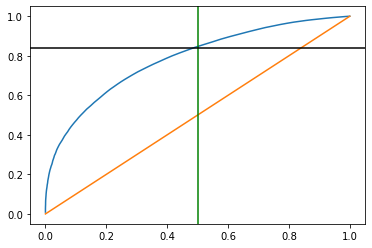

In [31]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
ax.plot(ROC_Pile[0:], ROC_NoPile[0:])
ax.plot([0.0, 1.0], [0.0, 1.0])

plt.axvline(x = 0.5, color = 'green')
plt.axhline(y = 0.84, color = 'black')
plt.show()

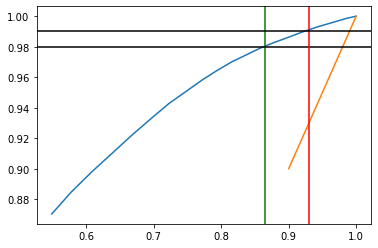

In [32]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
ax.plot(ROC_Pile[75:], ROC_NoPile[75:])
ax.plot([0.9, 1.0], [0.9, 1.0])

plt.axvline(x = 0.865, color = 'green')
plt.axhline(y = 0.98, color = 'black')

plt.axvline(x = 0.93, color = 'red')
plt.axhline(y = 0.99, color = 'black')


plt.show()
## using test data

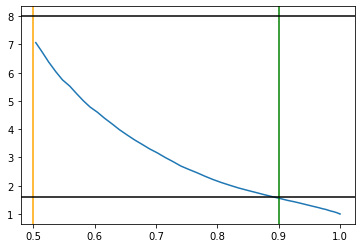

In [45]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
#ax.plot(ROC_Pile[5:], 1/ROC_NoPile[5:])

ax.plot(ROC_NoPile[45:], 1/ROC_Pile[45:])
plt.axvline(x = 0.9 , color = 'green')
plt.axvline(x = 0.5 , color = 'orange')
plt.axhline(y = 1.6 , color = 'black')
plt.axhline(y = 8 , color = 'black')
plt.show()

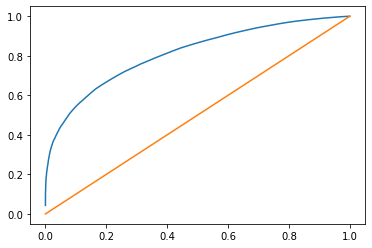

In [35]:
import matplotlib.pyplot as plt
ROC_NoPile = VecROC(hist_NoPile[0])
ROC_Pile = VecROC(hist_Pile[0])
fig, ax = plt.subplots()
ax.plot(ROC_Pile, ROC_NoPile)
ax.plot([0.0, 1.0], [0.0, 1.0])
plt.show()

In [ ]:
len(list(np.where(np.array(df[df["eventNumber"]==47081807].cluster_ENG_CALIB_TOT.values) == 0, 1, 0)))

In [ ]:
eventNumbers